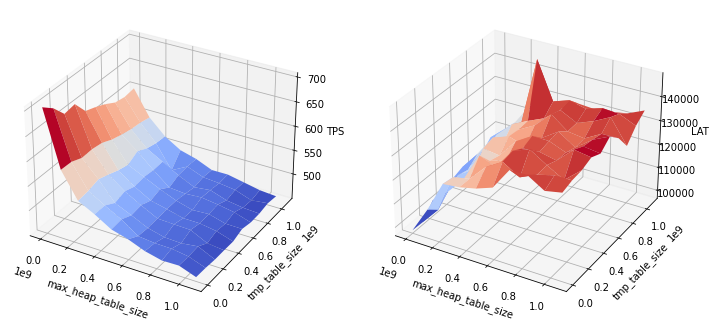

In [34]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

path = "/home/root3/Tuning/benchbase_tpcc_2_16_1705841599.0453835"
file_path = os.path.join(path, "results_tps.res")
with open(file_path, "r") as f:
    lines = f.readlines()
x = np.linspace(1024, 1073741824, 10, dtype=np.int32)
y = np.linspace(16384, 1073741824, 10, dtype=np.int32)
Y, X = np.meshgrid(y, x)
z1, Z1 = [], []
z2, Z2 = [], []
for i in range(1, len(lines)):
    line = lines[i]
    info = eval(line)
    z1.append(info["Throughput (requests/second)"])
    z2.append(info["Latency Distribution"]["99th Percentile Latency (microseconds)"])
    if len(z1) == 10:
        Z1.append(z1)
        z1 = []
    if len(z2) == 10:
        Z2.append(z2)
        z2 = []
Z1 = np.array(Z1)
Z2 = np.array(Z2)
# 创建三维图像对象
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# 绘制曲面
ax1.plot_surface(X, Y, Z1, cmap=plt.get_cmap("coolwarm"))
ax2.plot_surface(X, Y, Z2, cmap=plt.get_cmap("coolwarm"))
# 设置轴标签
ax1.set_xlabel('max_heap_table_size')
ax1.set_ylabel('tmp_table_size')
ax1.set_zlabel('TPS')

ax2.set_xlabel('max_heap_table_size')
ax2.set_ylabel('tmp_table_size')
ax2.set_zlabel('LAT')
 
# 显示图像
plt.show()

In [1]:
a = 2